<h1>Linear regression: Training and Validation Data</h1> 

In [1]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn,optim

In [2]:
# Create Data class

from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    
    # Constructor
    def __init__(self, train = True):
            self.x = torch.arange(-3, 3, 0.1).view(-1, 1)
            self.f = -3 * self.x + 1
            self.y = self.f + 0.1 * torch.randn(self.x.size())
            self.len = self.x.shape[0]
            
            #outliers 
            if train == True:
                self.y[0] = 0
                self.y[50:55] = 20
            else:
                pass
      
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

In [3]:
# Create training dataset and validation dataset

train_data = Data()
val_data = Data(train = False)

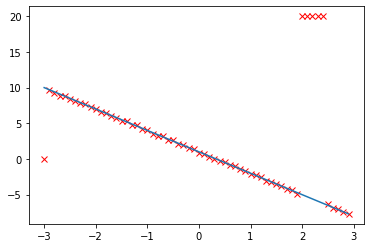

In [4]:
#Overlay the training points in red over the function that generated the data. Notice the outliers at x=-3 and around x=2:
# Plot out training points

plt.plot(train_data.x.numpy(), train_data.y.numpy(), 'xr')
plt.plot(train_data.x.numpy(), train_data.f.numpy())
plt.show()

In [5]:
# Create Linear Regression Class

from torch import nn

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # Prediction function
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [6]:
# Create MSELoss function and DataLoader

criterion = nn.MSELoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)

Create a list with different learning rates and a tensor (can be a list) for the training and validating cost/total loss. Include the list MODELS, which stores the training model for every value of the learning rate. 

In [7]:
# Create Learning Rate list, the error lists and the MODELS list

learning_rates=[0.0001, 0.001, 0.01, 0.1]

train_error=torch.zeros(len(learning_rates))
validation_error=torch.zeros(len(learning_rates))

MODELS=[]

Try different values of learning rates, perform stochastic gradient descent, and save the results on the training data and validation data. Finally, save each model in a list.

In [8]:
# Define the train model function and train the model

def train_model_with_lr (iter, lr_list):
    
    # iterate through different learning rates 
    for i, lr in enumerate(lr_list):
        model = linear_regression(1, 1)
        optimizer = optim.SGD(model.parameters(), lr = lr)
        for epoch in range(iter):
            for x, y in trainloader:
                yhat = model(x)
                loss = criterion(yhat, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # train data
        Yhat = model(train_data.x)
        train_loss = criterion(Yhat, train_data.y)
        train_error[i] = train_loss.item()      #The items() method returns a view object. The view object contains the key-value pairs of the dictionary, as tuples in a list.
    
        # validation data
        Yhat = model(val_data.x)
        val_loss = criterion(Yhat, val_data.y)
        validation_error[i] = val_loss.item()
        MODELS.append(model)

train_model_with_lr(10, learning_rates)

<h2 id="Result">View the Results</h2>


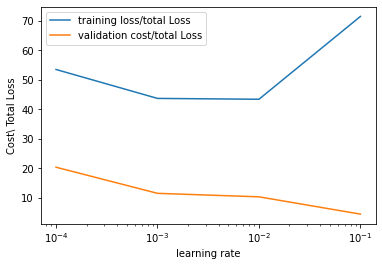

In [9]:
# Plot the training loss and validation loss

plt.semilogx(np.array(learning_rates), train_error.numpy(), label = 'training loss/total Loss')
plt.semilogx(np.array(learning_rates), validation_error.numpy(), label = 'validation cost/total Loss')
plt.ylabel('Cost\ Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

i [[1.491029 ]
 [1.4460962]
 [1.4011632]]
i [[5.7714453]
 [5.655702 ]
 [5.5399585]]
i [[6.544577 ]
 [6.4111657]
 [6.277754 ]]
i [[13.944818]
 [13.526793]
 [13.108766]]


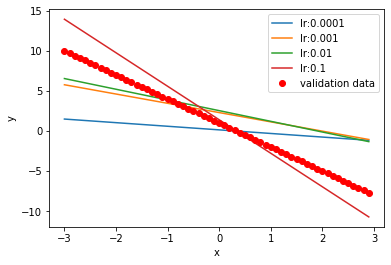

In [10]:
# Plot the predictions

i = 0
for model, learning_rate in zip(MODELS, learning_rates):
    yhat = model(val_data.x)
    plt.plot(val_data.x.numpy(), yhat.detach().numpy(), label = 'lr:' + str(learning_rate))
    print('i', yhat.detach().numpy()[0:3])
plt.plot(val_data.x.numpy(), val_data.f.numpy(), 'or', label = 'validation data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

<h2 id="Stop">Early Stopping and Saving the Mode</h2>

In [11]:
# Create the model object
model = linear_regression(1, 1)


# Create optimizer, cost function and data loader object
optimizer = optim.SGD(model.parameters(), lr = 0.1)
criterion = nn.MSELoss()
trainloader = DataLoader(dataset = train_data, batch_size = 1)

In [12]:
# Train the model

LOSS_TRAIN = []
LOSS_VAL = []
n=1;
min_loss = 1000

def train_model_early_stopping(epochs, min_loss):
    for epoch in range(epochs):
        for x, y in trainloader:
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train = criterion(model(train_data.x), train_data.y).data
            loss_val = criterion(model(val_data.x), val_data.y).data
            LOSS_TRAIN.append(loss_train)
            LOSS_VAL.append(loss_val)
            if loss_val < min_loss:
                value = epoch
                min_loss = loss_val
                torch.save(model.state_dict(), 'best_model.pt')
#the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. 
                

train_model_early_stopping(20, min_loss)

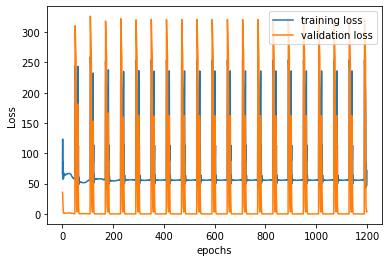

In [13]:
# Plot the loss

plt.plot(LOSS_TRAIN, label = 'training loss')
plt.plot(LOSS_VAL, label = 'validation loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(loc = 'upper right')
plt.show()

In [14]:
# Create a new linear regression model object

model_best = linear_regression(1, 1)

# Assign the best model to model_best

model_best.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

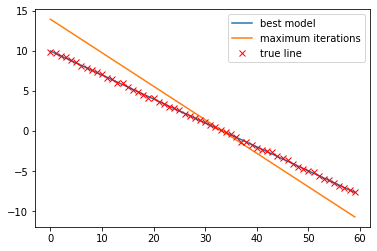

In [15]:
plt.plot(model_best(val_data.x).data.numpy(), label = 'best model')
plt.plot(model(val_data.x).data.numpy(), label = 'maximum iterations')
plt.plot(val_data.y.numpy(), 'rx', label = 'true line')
plt.legend()
plt.show()